In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense
# Import resample and shuffle
from sklearn.utils import resample, shuffle

In [ ]:
# Load datasets
d_path = '/content/drive/MyDrive/Internship/d_tweets.csv'
non_d_path = '/content/drive/MyDrive/Internship/non_d_tweets.csv'

In [ ]:
d_tweet_df['label'].value_counts()

,count
label,
1,3496


In [ ]:
non_d_tweet_df['label'].value_counts()

,count
label,
0,4809


In [ ]:
d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Assign labels and combine datasets
non_d_tweet_df['label'] = 0
d_tweet_df['label'] = 1

# Combine the data into a single DataFrame
tweets = pd.concat([d_tweet_df['tweet'], non_d_tweet_df['tweet']])
labels = pd.concat([d_tweet_df['label'], non_d_tweet_df['label']])



In [ ]:
# Assuming '0' is non-depression
majority_class = tweet_df[tweet_df['label'] == 0]
minority_class = tweet_df[tweet_df['label'] == 1]

# Undersample the non-depression-class
majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled non-depression-class with the depression-class
tweet_df = pd.concat([majority_undersampled, minority_class])

# Shuffle the balanced dataset
tweet_df = shuffle(tweet_df).reset_index(drop=True)
print(tweet_df['label'].value_counts())

label
1    3496
0    3496
Name: count, dtype: int64


In [ ]:
import nltk
# Download NLTK stopwords
nltk.download('stopwords')
# Import the stopwords object from nltk.corpus
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    # Lowercase text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-alphabetical characters (punctuation, numbers)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


In [ ]:
# Apply preprocessing
tweet_df = tweets.apply(preprocess_text)

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(tweets)

# Pad the sequences to ensure uniform length
max_sequence_length = 100
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels should be in a numpy array or pandas series
y = labels.values

In [ ]:
!pip install gensim
from gensim.models import KeyedVectors
import numpy as np
import gensim.downloader as api # Import th

In [ ]:

# Load Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Create an embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Use the embedding matrix in the Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))

# Add LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.4))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarize the model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       4,317,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,317,600 (16.47 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,317,600 (16.47 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Define the model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

# Define the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model with the training data
model.fit(X_train, y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, y_test),  # Validate on the test set
          callbacks=[early_stopping, model_checkpoint, tensorboard])

Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 53s 242ms/step - accuracy: 0.7756 - loss: 0.4677 - val_accuracy: 0.8688 - val_loss: 0.2932
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 79s 228ms/step - accuracy: 0.8607 - loss: 0.3178 - val_accuracy: 0.8356 - val_loss: 0.3811
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 84s 240ms/step - accuracy: 0.8659 - loss: 0.3223 - val_accuracy: 0.8904 - val_loss: 0.2584
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.8841 - loss: 0.2831 - val_accuracy: 0.8989 - val_loss: 0.2494
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.8857 - loss: 0.2763 - val_accuracy: 0.8977 - val_loss: 0.2403
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 47s 228ms/step - accuracy: 0.9019 - loss: 0.2458 - val_accuracy: 0.8989 - val_loss: 0.2376
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.9002 - loss: 0.2473 - val_accuracy: 0.8934 - val_loss: 0.2384
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.8953 - loss: 0

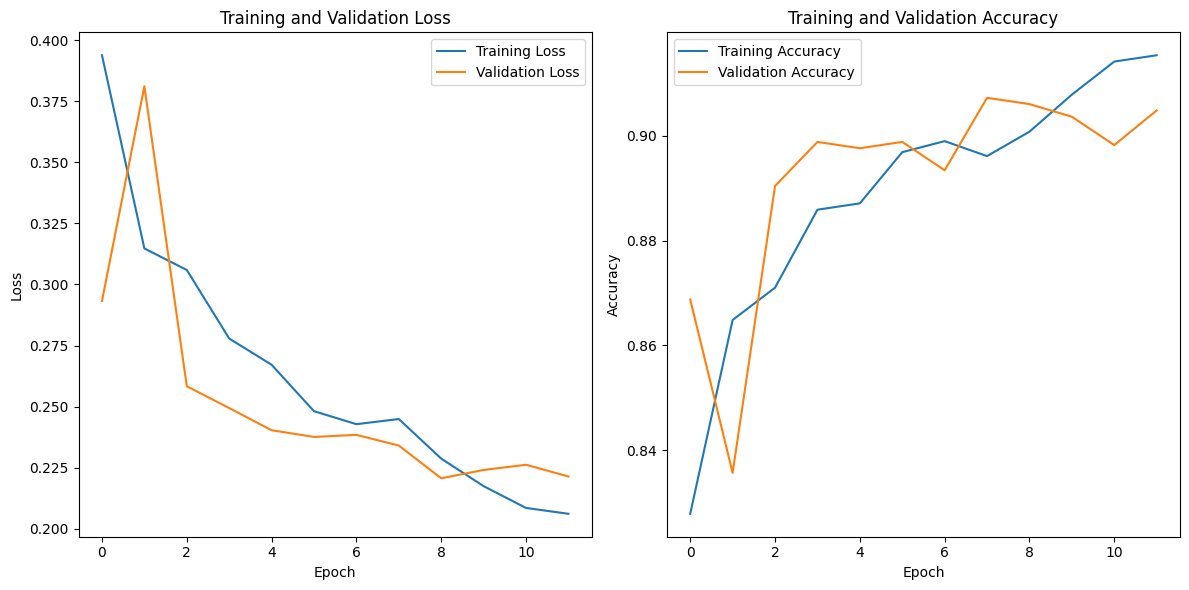

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step


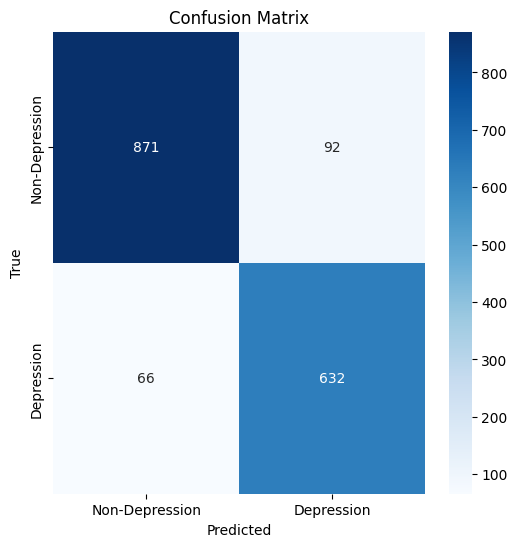

True Negative: 871
False Positive: 92
False Negative: 66
True Positive: 632


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Use 0.5 as the threshold for binary classification

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Depression', 'Depression'], yticklabels=['Non-Depression', 'Depression'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print confusion matrix values (True Negative, False Positive, False Negative, True Positive)
tn, fp, fn, tp = cm.ravel()
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")


In [ ]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Non-Depression', 'Depression']))


                precision    recall  f1-score   support

Non-Depression       0.93      0.90      0.92       963
    Depression       0.87      0.91      0.89       698

      accuracy                           0.90      1661
     macro avg       0.90      0.90      0.90      1661
  weighted avg       0.91      0.90      0.91      1661

